# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

In [ ]:
# Instalar librerías necesarias
#%pip install wfdb matplotlib scipy numpy pandas

### Recomendación: usar matplotlib, wfdb, scipy.io

Total de records encontrados: 8528


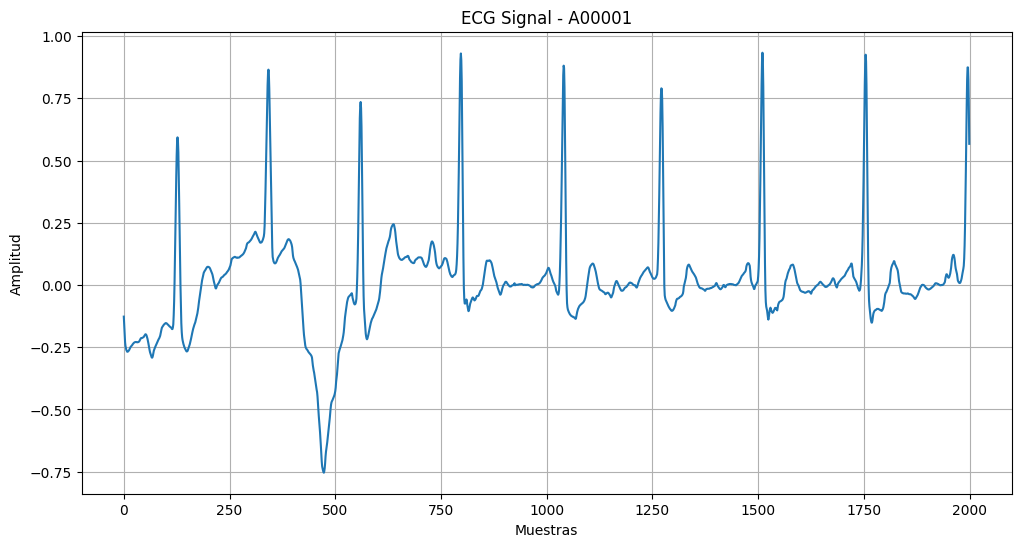

Record cargado: A00001
Metadatos: A00001 1 300 9000 05:05:15 1/05/2000 
A00001.mat 16+24 1000/mV 16 0 -127 0 0 ECG 



In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat

# Listar todos los records disponibles
def get_all_records(data_dir='training2017'):
    """
    Obtener lista de todos los records en el directorio
    """
    records = []
    for file in os.listdir(data_dir):
        if file.endswith('.hea'):
            record_name = file.replace('.hea', '')
            records.append(os.path.join(data_dir, record_name))
    return sorted(records)

# funcion para cargar y visualizar un record ECG, sus metadatos, frecuencia de muestreo y duración
def load_ecg_record(record_path):
    """
    Cargar un record ECG y sus metadatos desde un archivo .mat o .hea
    """
    # Cargar el record usando wfdb
    signal, fields = wfdb.rdsamp(record_path)
    
    # Cargar los metadatos si están disponibles
    metadata = {}
    if os.path.exists(record_path + '.hea'):
        with open(record_path + '.hea', 'r') as f:
            metadata['header'] = f.read()
    
    return signal, metadata

def plot_ecg(signal, record_path, title="ECG Signal"):
    
    # Visualizar la señal
    plt.figure(figsize=(12, 6))
    plt.plot(signal[:2000, 0])  # Primeros 2000 puntos del primer canal
    plt.title(f"ECG Signal - {os.path.basename(record_path)}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()

# obtener el directorio de los records disponibles
records_paths = get_all_records()
print(f"Total de records encontrados: {len(records_paths)}")

# Cargar el primer record
if records_paths:
    first_record = records_paths[0]
    # Cargar y visualizar el primer record
    signal, metadata = load_ecg_record(first_record)
    plot_ecg(signal, first_record)
    print(f"Record cargado: {os.path.basename(first_record)}")
    print("Metadatos:", metadata.get('header', 'No metadata available'))

## 2. Resumen del artículo base (Clifford et al., 2017)

El Desafío PhysioNet/CinC 2017 tiene como objetivo fomentar el desarrollo de algoritmos para clasificar, a partir de un único registro corto de derivaciones de ECG (entre 30 s y 60 s de duración), si el registro muestra ritmo sinusal normal, fibrilación auricular (FA), un ritmo alternativo o es demasiado ruidoso para ser clasificado.

Existen varios tipos de arritmias cardíacas que pueden clasificarse por:

- Origen: arritmia auricular, arritmia de unión o arritmia ventricular.
- Tasa: taquicardia (> 100 latidos por minuto (lpm) en adultos) o bradicardia (< 60 lpm en adultos).
- Mecanismo: automaticidad, reingreso, activado.
- Conducción AV: normal, retrasada, bloqueada.
- Duración: no sostenida (menos de 30 s) o sostenida (30 s o más).

La FA se define como una “taquiarritmia caracterizada por una activación auricular predominantemente descoordinada con el consiguiente deterioro de la función mecánica auricular”

Los detectores de FA basados en el análisis de la actividad auricular se basan en el análisis de la ausencia de ondas P o la presencia de fibrillas ondas f en el intervalo TQ.

contiene 8.528 registros de ECG 
sola derivación que duran desde 9 s hasta poco más de 60 s

Los registros de ECG se muestrearon a 300 Hz y fueron filtrados por paso de banda mediante el dispositivo AliveCor.


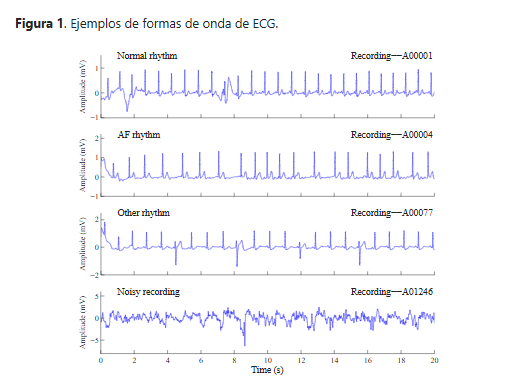








## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)

**Cantidad de señales**
8528

**Explicación de headers de una muestra**

- A00001: Nombre del registro (identificador único de la muestra de ECG).
- 1: Número de señales (en este caso, 1 canal de ECG).
- 300: **Frecuencia de muestreo** en Hz (300 muestras por segundo).
- 9000: Número total de muestras (**dura 30 segundos**, ya que 9000 / 300 = 30).
- 05:05:15: Hora de inicio de la grabación.
- 1/05/2000: Fecha de la grabación.

**Duración de las etiquetas**
Entre 30 - 60 segundos

**Descripción de las etiquetas**


Ritmo Normal – N

El ECG muestra un ritmo sinusal normal, es decir, la actividad eléctrica del corazón es regular y controlada por el nodo sinusal.

- Frecuencia cardíaca normal (60–100 latidos por minuto).
- Onda P presente y consistente antes de cada complejo QRS.
- Intervalo PR constante.
- Complejos QRS regulares y estrechos.

Fibrilación Auricular – A

El ECG presenta fibrilación auricular (AF o FA), una arritmia común en la cual las aurículas se contraen de forma rápida y desorganizada.

- Ausencia de ondas P claras.

- Actividad auricular caótica (ondas f o línea base irregular)
- Intervalos R-R irregulares (ritmo irregularmente irregular)
- Frecuencia ventricular variable.



Otro Ritmo – O

Alteraciones consistentes en los intervalos o formas de las ondas.

Ruidoso – P

La señal está contaminada por ruido o artefactos, impidiendo una interpretación diagnóstica confiable.
La señal es ilegible.


# Extracción de características

In [ ]:
# Instalar librerías adicionales para análisis de ECG
#%pip install biosppy neurokit2 pandas peakutils

In [2]:

import pandas as pd
import biosppy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def extract_rr_features(signal, fs=300):
    """
    Extraer características de intervalos RR de una señal ECG
    
    Args:
        signal: señal ECG (array 1D)
        fs: frecuencia de muestreo (Hz)
    
    Returns:
        dict con características RR o None si hay error
    """
    try:
        # Procesar señal ECG para detectar picos R
        ecg_processed = biosppy.signals.ecg.ecg(signal=signal.flatten(), 
                                               sampling_rate=fs, 
                                               show=False)
        
        # Obtener posiciones de los picos R
        rpeaks = ecg_processed['rpeaks']
        
        # Calcular intervalos RR en milisegundos
        if len(rpeaks) < 3:  # Necesitamos al menos 3 picos para calcular intervalos
            return None
            
        rr_intervals = np.diff(rpeaks) / fs * 1000  # Convertir a ms
        
        # Filtrar intervalos RR anómalos (entre 300ms y 2000ms)
        rr_intervals = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 2000)]
        
        if len(rr_intervals) < 2:
            return None
        
        # Calcular características estadísticas
        features = {
            'mean_rr': np.mean(rr_intervals),
            'std_rr': np.std(rr_intervals),
            'skew_rr': stats.skew(rr_intervals),
            'kurt_rr': stats.kurtosis(rr_intervals) + 3  # Kurtosis con exceso + 3
        }
        
        return features
        
    except Exception as e:
        print(f"Error procesando señal: {e}")
        return None

def load_labels(labels_file='training2017/REFERENCE.csv'):
    """
    Cargar etiquetas desde archivo CSV
    """
    try:
        # Intentar cargar como CSV
        labels_df = pd.read_csv(labels_file, header=None, names=['record', 'label'])
    except:
        # Si no es CSV, intentar como archivo de texto separado por comas
        with open(labels_file, 'r') as f:
            lines = f.readlines()
        
        records = []
        labels = []
        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                records.append(parts[0])
                labels.append(parts[1])
        
        labels_df = pd.DataFrame({'record': records, 'label': labels})
    
    return labels_df

def process_all_records(max_records=None):
    """
    Procesar todos los records y extraer características RR
    
    Args:
        max_records: límite de records a procesar (None para todos)
    """
    records_paths = get_all_records()
    
    if max_records:
        records_paths = records_paths[:max_records]
    
    # Cargar etiquetas
    try:
        labels_df = load_labels()
        print(f"Etiquetas cargadas: {len(labels_df)} registros")
    except Exception as e:
        print(f"Error cargando etiquetas: {e}")
        return None
    
    features_list = []
    processed_count = 0
    
    for i, record_path in enumerate(records_paths):
        try:
            # Extraer nombre del record
            record_name = os.path.basename(record_path)
            
            # Buscar etiqueta correspondiente
            label_row = labels_df[labels_df['record'] == record_name]
            if label_row.empty:
                continue
                
            label = label_row['label'].iloc[0]
            
            # Cargar señal
            signal, _ = load_ecg_record(record_path)
            
            # Extraer características RR
            features = extract_rr_features(signal)
            
            if features is not None:
                features['label'] = label
                features_list.append(features)
                processed_count += 1
                
                if processed_count % 100 == 0:
                    print(f"Procesados: {processed_count} records")
            
        except Exception as e:
            print(f"Error procesando {record_path}: {e}")
            continue
    
    print(f"Total procesados exitosamente: {processed_count}")
    return pd.DataFrame(features_list)

# Procesar todos los records (puedes limitar con max_records para pruebas)
print("Iniciando extracción de características RR...")
features_df = process_all_records(max_records=100)  # Limitar a 100 para prueba

if features_df is not None and not features_df.empty:
    # Mostrar estadísticas
    print(f"\nDataset generado con {len(features_df)} muestras")
    print(f"Distribución de etiquetas:")
    print(features_df['label'].value_counts())
    
    # Mostrar primeras filas
    print(f"\nPrimeras 5 filas:")
    print(features_df.head())
    
    # Guardar archivo CSV
    output_file = 'ecg_rr_features_extracted.csv'
    features_df.to_csv(output_file, index=False)
    print(f"\nArchivo guardado como: {output_file}")
    
else:
    print("No se pudo generar el dataset")

Iniciando extracción de características RR...
Etiquetas cargadas: 8528 registros
Procesados: 100 records
Total procesados exitosamente: 100

Dataset generado con 100 muestras
Distribución de etiquetas:
label
N    58
O    29
A    10
~     3
Name: count, dtype: int64

Primeras 5 filas:
      mean_rr      std_rr   skew_rr    kurt_rr label
0  761.666667   33.093435  0.133439   1.811500     N
1  867.575758  251.388431 -1.267438   2.884663     N
2  731.434599   79.934367 -2.918037  14.419521     N
3  947.111111  178.938709  0.482376   2.062416     A
4  542.324159  223.975072  1.170247   2.981416     A

Archivo guardado como: ecg_rr_features_extracted.csv


In [ ]:
# Para procesar TODOS los records (esto puede tomar tiempo)
print("Procesando TODOS los records del dataset...")
features_df_complete = process_all_records()  # Sin límite

if features_df_complete is not None:
    print(f"\nDataset completo generado con {len(features_df_complete)} muestras")
    print(f"Distribución de etiquetas:")
    print(features_df_complete['label'].value_counts())
    
    # Guardar archivo CSV completo
    output_file_complete = 'ecg_rr_features_complete.csv'
    features_df_complete.to_csv(output_file_complete, index=False)
    print(f"\nArchivo completo guardado como: {output_file_complete}")

# Análisis preliminares (Código debajo)
(Sólo analizando los primeros 100)
¿Qué variables parecen diferenciar más entre clases?

¿Qué aspectos del dataset llaman la atención?

In [ ]:
#%pip install seaborn

=== ANÁLISIS PRELIMINAR DEL DATASET ===
Total de muestras: 100
Distribución de etiquetas:
label
N    58
O    29
A    10
~     3
Name: count, dtype: int64

=== ESTADÍSTICAS POR CLASE ===

--- Clase N ---
N° muestras: 58
       mean_rr  std_rr  skew_rr  kurt_rr
count    58.00   58.00    58.00    58.00
mean    870.97   63.81    -0.55     6.00
std     122.05   59.47     1.45     5.19
min     640.52    7.53    -3.78     1.69
25%     774.60   23.30    -1.26     2.40
50%     866.01   40.94    -0.30     3.49
75%     959.80   85.26     0.22     7.86
max    1125.60  256.03     4.33    22.34

--- Clase A ---
N° muestras: 10
       mean_rr  std_rr  skew_rr  kurt_rr
count    10.00   10.00    10.00    10.00
mean    697.24  142.32     0.51     2.84
std     119.68   63.32     0.51     1.07
min     542.32   52.78    -0.29     1.67
25%     630.83   94.31     0.17     2.18
50%     671.71  133.22     0.52     2.72
75%     760.14  196.28     0.94     3.01
max     947.11  226.81     1.17     5.52

--- Clase

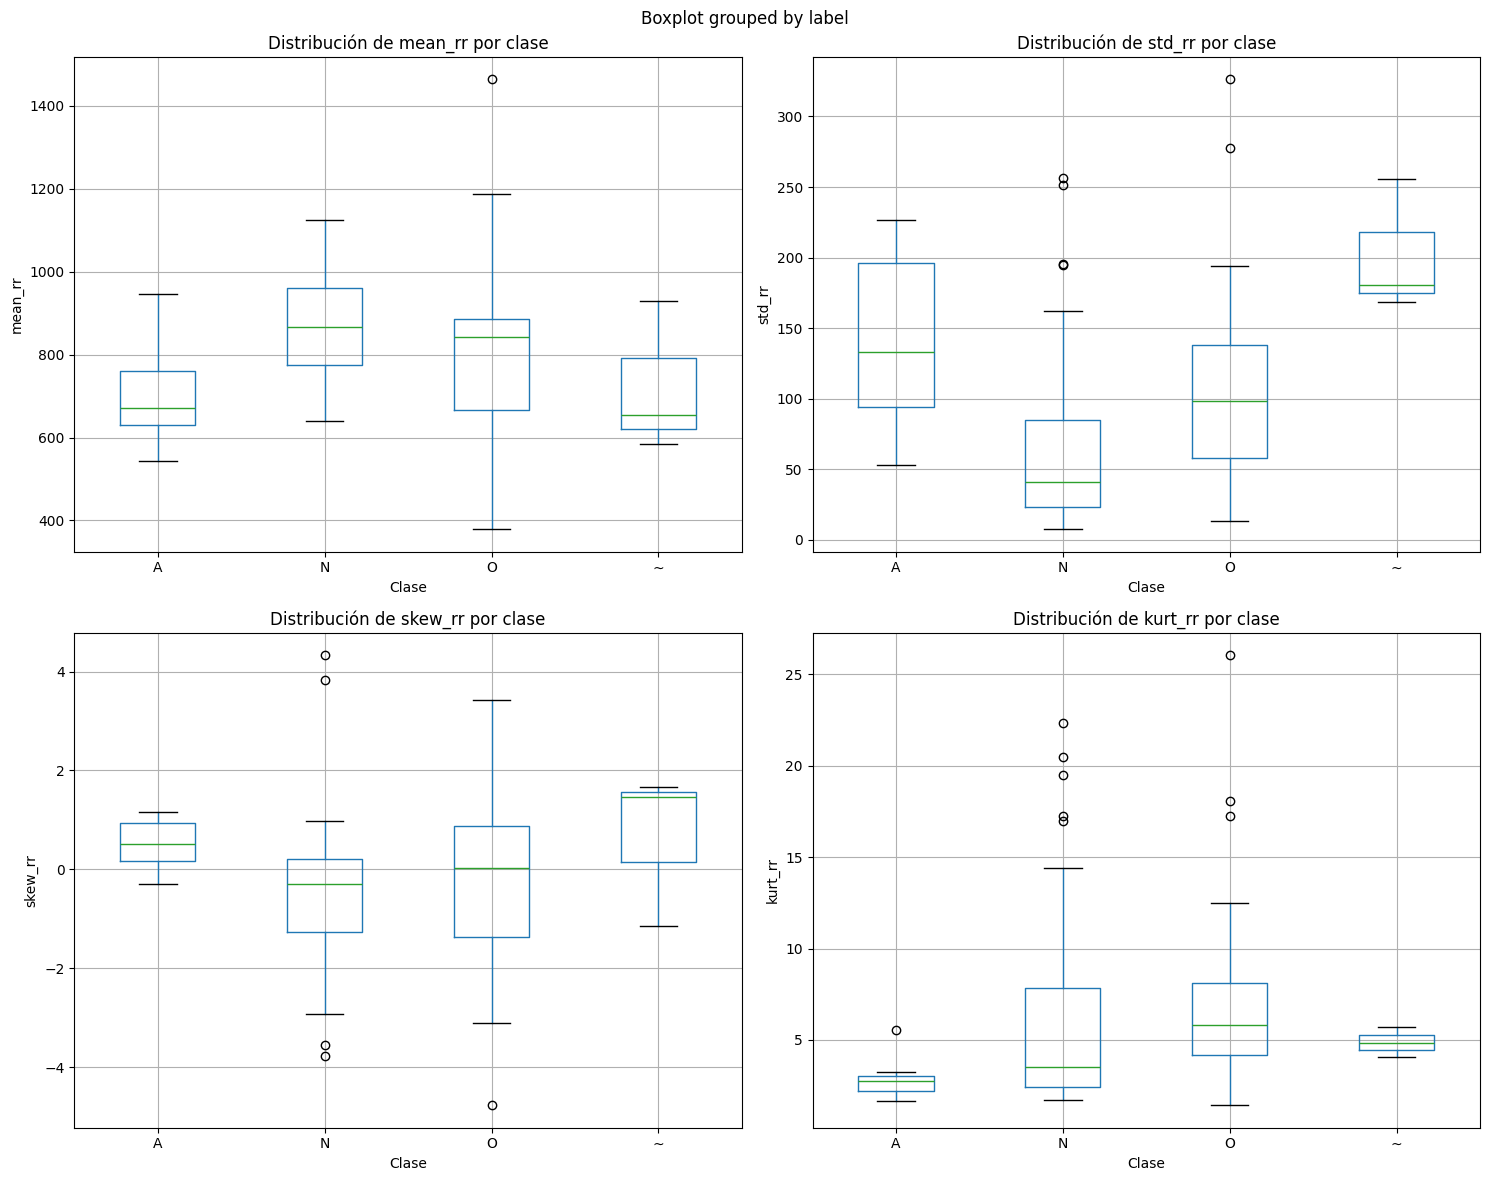


=== MATRIZ DE CORRELACIÓN ===
         mean_rr  std_rr  skew_rr  kurt_rr
mean_rr    1.000  -0.042   -0.255   -0.111
std_rr    -0.042   1.000    0.037    0.028
skew_rr   -0.255   0.037    1.000   -0.218
kurt_rr   -0.111   0.028   -0.218    1.000


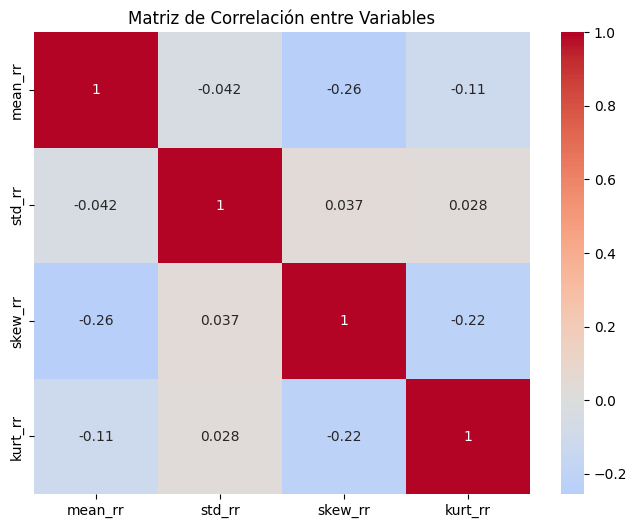


=== ASPECTOS QUE LLAMAN LA ATENCIÓN ===
1. DESBALANCE DE CLASES:
   N: 58 muestras (58.0%)
   O: 29 muestras (29.0%)
   A: 10 muestras (10.0%)
   ~: 3 muestras (3.0%)

2. VALORES EXTREMOS:
   mean_rr: 378.8 - 1464.0 ms
   std_rr: 7.5 - 326.3 ms
   skew_rr: -4.77 - 4.33
   kurt_rr: 1.42 - 26.05

3. POSIBLES OUTLIERS:
   mean_rr: 2 outliers (2.0%)
   std_rr: 1 outliers (1.0%)
   skew_rr: 5 outliers (5.0%)
   kurt_rr: 8 outliers (8.0%)

4. MUESTRAS PROBLEMÁTICAS:
   Taquicardia extrema (mean_rr < 400ms): 1 muestras
   Bradicardia extrema (mean_rr > 1200ms): 1 muestras
   Alta variabilidad (std_rr > 200ms): 8 muestras


In [3]:
# Análisis preliminar del dataset extraído
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el dataset extraído
df = pd.read_csv('ecg_rr_features_extracted.csv')

print("=== ANÁLISIS PRELIMINAR DEL DATASET ===")
print(f"Total de muestras: {len(df)}")
print(f"Distribución de etiquetas:")
print(df['label'].value_counts())
print()

# Estadísticas descriptivas por clase
print("=== ESTADÍSTICAS POR CLASE ===")
for label in df['label'].unique():
    print(f"\n--- Clase {label} ---")
    subset = df[df['label'] == label]
    print(f"N° muestras: {len(subset)}")
    print(subset[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']].describe().round(2))

# Análisis de diferencias entre clases
print("\n=== VARIABLES QUE MÁS DIFERENCIAN ENTRE CLASES ===")

# Calcular medias por clase
means_by_class = df.groupby('label')[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']].mean()
print("\nMedias por clase:")
print(means_by_class.round(2))

# Calcular coeficiente de variación entre clases para cada variable
print("\nCoeficiente de variación entre clases (mayor = más discriminativo):")
for col in ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']:
    cv = means_by_class[col].std() / means_by_class[col].mean()
    print(f"{col}: {cv:.4f}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    
    # Boxplot por clase
    df.boxplot(column=feature, by='label', ax=ax)
    ax.set_title(f'Distribución de {feature} por clase')
    ax.set_xlabel('Clase')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

# Matriz de correlación
print("\n=== MATRIZ DE CORRELACIÓN ===")
corr_matrix = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']].corr()
print(corr_matrix.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación entre Variables')
plt.show()

print("\n=== ASPECTOS QUE LLAMAN LA ATENCIÓN ===")

# 1. Desbalance de clases
label_counts = df['label'].value_counts()
print(f"1. DESBALANCE DE CLASES:")
for label, count in label_counts.items():
    percentage = (count/len(df))*100
    print(f"   {label}: {count} muestras ({percentage:.1f}%)")

# 2. Rangos de valores extremos
print(f"\n2. VALORES EXTREMOS:")
print(f"   mean_rr: {df['mean_rr'].min():.1f} - {df['mean_rr'].max():.1f} ms")
print(f"   std_rr: {df['std_rr'].min():.1f} - {df['std_rr'].max():.1f} ms") 
print(f"   skew_rr: {df['skew_rr'].min():.2f} - {df['skew_rr'].max():.2f}")
print(f"   kurt_rr: {df['kurt_rr'].min():.2f} - {df['kurt_rr'].max():.2f}")

# 3. Análisis de outliers
print(f"\n3. POSIBLES OUTLIERS:")
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"   {feature}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

# 4. Identificar muestras problemáticas
print(f"\n4. MUESTRAS PROBLEMÁTICAS:")
# RR intervals muy cortos (taquicardia extrema)
tachycardia = df[df['mean_rr'] < 400]  # >150 bpm
print(f"   Taquicardia extrema (mean_rr < 400ms): {len(tachycardia)} muestras")

# RR intervals muy largos (bradicardia extrema)  
bradycardia = df[df['mean_rr'] > 1200]  # <50 bpm
print(f"   Bradicardia extrema (mean_rr > 1200ms): {len(bradycardia)} muestras")

# Variabilidad muy alta (posible ruido)
high_variability = df[df['std_rr'] > 200]
print(f"   Alta variabilidad (std_rr > 200ms): {len(high_variability)} muestras")